In [2]:
import ipywidgets as widgets
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from pylab import rcParams
from ipywidgets import HBox, VBox
from statistics import mean
from math import log10 as log
import linecache

plt.rcParams["figure.figsize"] = 12,4
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial']

# from google.colab import drive
# drive.mount('/content/drive')
# Filename = '/content/drive/MyDrive/Postdoc Spain/Python files/Jupyter/2023-11-23 Ptoep DPA FINAL test/TTAUC_2023-11-23 BIG Ptoep Dpa test final repeat'

Filename = 'TTAUC_2024-03-18 PdTPBP Tips Anc new'

#Get volumes and flow rates
pump_info = linecache.getline(f'{Filename}.txt', 2)
print(pump_info)
Total_FR = int(pump_info.split("Total flow rate: ",1)[1].split(' ul/min')[0])
System_volume = int(pump_info.split(' ul/min, system volume: ',1)[1].split(' ul')[0])
Volume_interval = int(pump_info.split('volume interval: ',1)[1].split(' ul')[0])
# print(Total_FR, System_volume, Volume_interval)

pddata = pd.read_csv(f'{Filename}.txt',sep='\t', header=3)
meta=10
# print(pddata)
# data = pddata.to_numpy()
wavelengths_pd = np.array((list(pddata)[meta:]))
wavelength_axis = np.around(wavelengths_pd.astype(float),1)
# print(wavelength_axis)

p_index = [] #number of pl measures
n_index = [] #number of abs measures
na_index = [] #number of abs after measures
power_pd = [] #powers
x=0
p=0
n=0 #Abs0 is absorption reference spectrum
# n=-2 
data_length = len(pddata.iloc[:,0])
start_iteration = -1

for x in range(data_length): # find number of powers and total measurements
#     print(x, pddata.iloc[x,1])
    if "Absa" in pddata.iloc[x,1]:
        na_index.append(x)
        continue
    elif "Abs" in pddata.iloc[x,1]:
        if x>0:
            n += 1
            n_index.append(x)
            if n == x:
                start_iteration += 1
        continue

    else:
      if n==2:
          power_pd.append(float(pddata.iloc[x,1]))
      p += 1
      p_index.append(x)

n_pl = n - start_iteration

power_axis = np.array(power_pd)
# power_axis_area = 0.001*power_axis/(3.14*0.05**2) #in W/cm2
print(f"scans: {n}, power points: {round(p/n_pl, 1)}")
print(f"experiment time: {round(pddata.iloc[-1,0]/60, 1)} minutes")
print(power_pd)
print(n,n_pl,p)
print(start_iteration)

Total flow rate: 1000 ul/min, system volume: 1050 ul, volume interval: 300 ul

scans: 128, power points: 16.0
experiment time: 235.1 minutes
[0.0098, 0.0186, 0.0302, 0.0547, 0.0906, 0.1643, 0.2784, 0.4785, 0.8131, 1.4699, 2.4851, 4.4119, 7.4058, 12.8357, 22.588, 39.4293]
128 128 2048
0


[Text(0.5, 0, 'Scan #'), Text(0, 0.5, 'Absorbance, OD')]

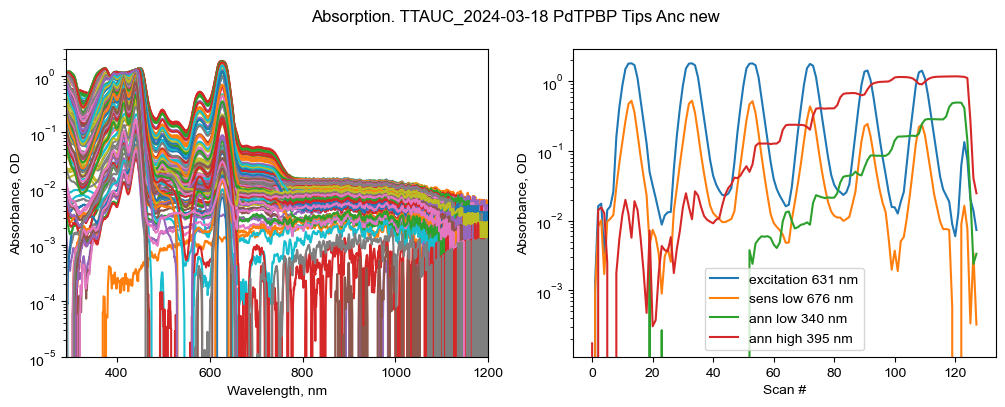

In [3]:
# Create concentration array based on absorbance values
plt.rcParams["figure.figsize"] = 12,4

# # import blank transmission spectrum
# Filename_abs = 'Toluene transmission'
# pddata_abs = pd.read_csv(f'{Filename_abs}.txt',sep='\t', header=3)
# Reference_abs = np.array(pddata_abs.iloc[0,meta:])
Reference_abs = np.array(pddata.iloc[0,meta:])

# create array of absorbance values for emitter and sensitizer
sens_abs = np.zeros(n)
emit_abs = np.zeros(n)
emit_abs_high = np.zeros(n)
wl_exc_abs = np.zeros(n)
ratio_abs = np.zeros(n)
Absorbance_array = np.zeros((len(wavelength_axis),n))

#wavelength to calculate emiter/sensitizer concentrations at two points for precision. Also to eliminate efffects of absorbance saturation
wl_emit = 340 
wl_emit_high = 395
wl_sens = 580
bg = 900 #background wavelength in nm
wl_exc = 631 #excitation wavelength to calculate quantum yield

fig_abs, ax = plt.subplots(1,2)
fig_abs.suptitle(f"Absorption. {Filename}")

wl_emit_index = (np.abs(wavelength_axis - wl_emit)).argmin()
wl_emit_high_index = (np.abs(wavelength_axis - wl_emit_high)).argmin()
wl_sens_index = (np.abs(wavelength_axis - wl_sens)).argmin()
bg_index = (np.abs(wavelength_axis - bg)).argmin()
wl_exc_index = (np.abs(wavelength_axis - wl_exc)).argmin()

# get first absorbance spectra to substract from the rest.
Signal_abs = np.array(pddata.iloc[n_index[0],meta:])
Absorbance_first = [log(Reference_abs[x] / Signal_abs[x]) if Signal_abs[x]>0 and Reference_abs[x]>0 else 0.0 for x in range(len(wavelength_axis))]
Absorbance_first = np.zeros(len(wavelength_axis))

for y in range(n):
    Signal_abs = np.array(pddata.iloc[n_index[y],meta:])
    Absorbance_current = [log(Reference_abs[x] / Signal_abs[x]) if Signal_abs[x]>0 and Reference_abs[x]>0 else 0.0 for x in range(len(wavelength_axis))]
    Absorbance = np.array(Absorbance_current) - np.array(Absorbance_first)
    
    bg_intensity = mean(Absorbance[bg_index-2:bg_index+2])
#     Absorbance = np.array(Absorbance) - bg_intensity
    
    emit_abs[y] = Absorbance[wl_emit_index]
    emit_abs_high[y] = Absorbance[wl_emit_high_index] 
    sens_abs[y] = Absorbance[wl_sens_index] 

#     Remove sensitizer absorbance from emitter
    emit_abs[y] = emit_abs[y] - sens_abs[y] * 0.94    
    emit_abs_high[y] = emit_abs_high[y] - sens_abs[y] * 1.2
    
    Absorbance_array[:,y] = np.array(Absorbance) 

    wl_exc_abs[y] = mean(Absorbance[wl_exc_index-1:wl_exc_index+1]) 
#     wl_exc_abs[y] = sens_abs * 5.7 #because of ratio 535nm/500nm
    
#     ratio_abs[y] = wl_exc_abs[y]/sens_abs[y]

    ax[0].plot(wavelength_axis, Absorbance_array[:,y])

ax[0].set(xlabel='Wavelength, nm', ylabel='Absorbance, OD')
ax[0].set_ylim(bottom=0.00001, top = 3)
ax[0].set_xlim(left=290, right=1200)
ax[0].set_yscale("log")    

ax[1].plot(range(n), wl_exc_abs, label=f'excitation {wl_exc} nm') 
ax[1].plot(range(n), sens_abs, label=f'sens low {wl_sens_index} nm')    
ax[1].plot(range(n), emit_abs, label=f'ann low {wl_emit} nm')
ax[1].plot(range(n), emit_abs_high, label=f'ann high {wl_emit_high} nm')
ax[1].set_yscale("log")   
# ax[1].plot(range(n), ratio_abs/10,  "k--", label='sensitizer ratio /10')

ax[1].legend()
# ax[1].set_ylim(bottom=0)
ax[1].set(xlabel='Scan #', ylabel='Absorbance, OD')

In [4]:
# Compare set and measured concentrations. Use volume insted of measurements

plt.rcParams["figure.figsize"] = 6,4
plt.rcParams['figure.dpi'] = 100
plt.rcParams.update({'font.size': 14})
# plt.suptitle(f"Measured and set concentrations")

path = 0.15 #path in flow cell in cm
emit_FR = np.array(pddata.iloc[:,4]) #read emitter and sensitizer flowrates
sens_FR = np.array(pddata.iloc[:,3])
system_iteration = int(System_volume/Volume_interval) #system volume divided by interval volume

# PdTPBP 8.8mg 920 g/mol 0.4 mM 24ml
# Tips-An 19.3mg 539g/mol 4mM 9ml 
emit_eps = 1E3 #M-1cm-1 at 340nm of emitter 0.7E3
emit_high_eps = 1.5E4 #M-1cm-1 at 393nm of emitter [https://digital.csic.es/bitstream/10261/283378/2/Bharmoria_JMatChemA_2022_suppl_editorial.pdf]
# emit_eps = 0.7E3 #M-1cm-1 at 340nm of emitter 0.7E3
# emit_high_eps = 1E4 #M-1cm-1 at 393nm of emitter ["TIPS-anthracene: a singlet fission or triplet fusion material?"]
sens_eps = 1.2E4 #M-1cm-1 at 580nm
sens_eps_exc = 7.9E4 #M-1cm-1 at 500nm
init_conc_emit = 3.5E-3 #Molar
init_conc_sens = 4E-4 #Molar

sens_conc = np.zeros(n)
emit_conc = np.zeros(n)
emit_conc_set = np.zeros(n)
sens_conc_set = np.zeros(n)

# Volume = range(n) * Volume_interval / 1000 #all volumes in ml
Volume = np.array([float(x)*Volume_interval/1000 for x in range(n)])
Volume_set = Volume + System_volume/1000 

# estimate emitter sensitizer concentrations and plot
for x in range(n):
    emit_conc_set[x] = emit_FR[n_index[x]] / Total_FR * init_conc_emit
    sens_conc_set[x] = sens_FR[n_index[x]] / Total_FR * init_conc_sens

# interpolate set concnetrations on Volume and take average for low annihilator concentrations
emit_conc_set_interp = np.interp(Volume, Volume_set, emit_conc_set)

for x in range(n):    
    sens_conc[x] = wl_exc_abs[x]/sens_eps_exc/path
    if sens_conc[x] > 0.7E-5: #avoid absorption saturation by adding values from other peak
        sens_conc[x] = sens_abs[x]/sens_eps/path
    
    emit_conc[x] = emit_abs_high[x]/emit_high_eps/path
    emit_conc[x] = (emit_conc[x] + emit_conc_set_interp[x]) / 2 #take average with set conc
    
    if emit_conc[x] > 5E-4:
        emit_conc[x] = emit_abs[x]/emit_eps/path
    
##########################################################################################################

plt.scatter(Volume, emit_conc, label='Annihilator (Tips-Anc)', color="#388bc1ff")
# plt.plot(Volume, emit_new, 'b-')
plt.plot(Volume_set, emit_conc_set, "k--")

plt.scatter(Volume, sens_conc, label='Sensitizer (PdPTBP)', color="#ff7f2aff")
# plt.plot(Volume, sens_new, 'r-')
plt.plot(Volume_set, sens_conc_set, "k--")
plt.yscale("log")

plt.legend(fontsize=12)
# ax[0].set(xlim=wl_limits, xlabel='Wavelength, nm', ylabel='Absorbance, OD')
plt.xlim([0,40])
plt.ylim([2E-7,0.008])
plt.xlabel('Volume, ml')
plt.ylabel('Concentration, M')


Text(0, 0.5, 'Concentration, M')

[-6.58713266e-04  1.30347739e-03  1.60988991e-02  1.74956828e-02
  3.41083167e-03  1.41824206e-02  1.59761633e-02  2.57028569e-02
  1.97543221e-01  4.46966506e-01  8.91854016e-01  1.75727146e+00
  3.10161170e+00  3.44730215e+00  2.34847346e+00  1.15586243e+00
  5.50182397e-01  2.81947527e-01  1.50926793e-01  4.94764360e-02
  3.19435075e-02  2.10472593e-02  1.34930610e-02  8.74161226e-03
  1.18310855e-02  1.31444841e-02  1.32838758e-02  5.46401772e-02
  1.92344542e-01  4.22801184e-01  8.79789136e-01  1.79605441e+00
  3.13494558e+00  3.45384802e+00  2.32223807e+00  1.18677325e+00
  5.78328590e-01  3.07910760e-01  1.74556240e-01  7.33941606e-02
  4.37927434e-02  3.27264896e-02  2.69959800e-02  2.33331462e-02
  2.28607540e-02  2.43956779e-02  2.93225160e-02  6.66713299e-02
  2.04181071e-01  4.15545949e-01  8.77233226e-01  1.80811692e+00
  3.07462466e+00  3.40138114e+00  2.29799035e+00  1.17151204e+00
  5.47999548e-01  2.75644325e-01  1.46059387e-01  6.86961545e-02
  3.94212282e-02  2.83380

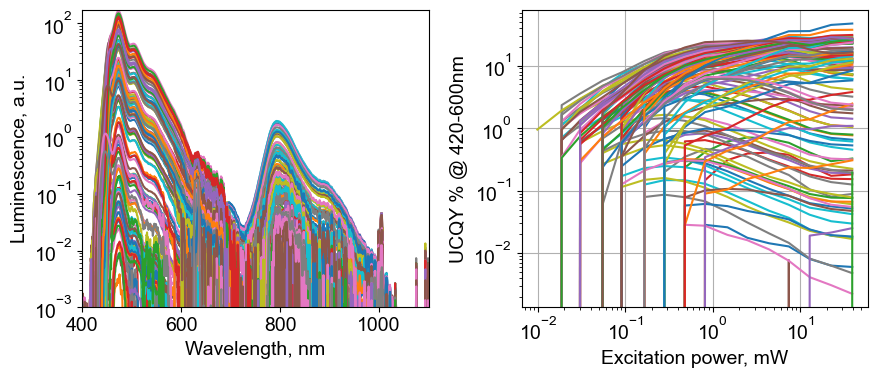

In [4]:
# Create array of luminescence intensity values, rows=power, columns=scans(concentration)
from scipy.signal import savgol_filter

######### replace with corrected values ###################
wl_exc_abs = sens_conc*sens_eps_exc*path
print(wl_exc_abs)
###############################################################

path_reabs = 0.1 #path lenght for reabsorption correction. Calibrate at low emitter/sens. concentration.

Emission_correction = np.loadtxt('Hellma Emission vs absorbance correction.txt',delimiter='\t')

plt.rcParams["figure.figsize"] = 9,4
plt.rcParams['figure.dpi'] = 100
plt.rcParams.update({'font.size': 14})
fig, ax = plt.subplots(1,2)

bg = 1100 #background wavelength in nm
wl_limits = [420,600] #Emission range to integrate
phos_limits = [750,1000] #phosphorescence range for TET efficiency

power_intensity = np.zeros((len(power_axis),n_pl))
PLQY = np.zeros((len(power_axis),n_pl))
MaxPL = np.zeros((len(power_axis),n_pl))
PhosQY = np.zeros((len(power_axis),n_pl))

q_array = []
q =  start_iteration + 2

bg_index = (np.abs(wavelength_axis - bg)).argmin()
wl_index_1 = (np.abs(wavelength_axis - wl_limits[0])).argmin()
wl_index_2 = (np.abs(wavelength_axis - wl_limits[1])).argmin()
phos_index_1 = (np.abs(wavelength_axis - phos_limits[0])).argmin()
phos_index_2 = (np.abs(wavelength_axis - phos_limits[1])).argmin()

PL_intensity = np.zeros(len(wavelength_axis))

for x in range(n_pl):
    if wl_exc_abs[x+start_iteration] < 0.002: #limit very low sensitizer absorbance values 
        PLQY[:,x] = 0
        PhosQY[:,x] = 0
        PL_intensity_uncorrected = PL_intensity
    else:
        #Emission intensity correction due to high absorbance in flow cell
        Int_corr_index = (np.abs(Emission_correction[:,0] - wl_exc_abs[x+start_iteration])).argmin()
        Int_corr = 1 / Emission_correction[Int_corr_index,1]
        
        for y in range(len(power_pd)):
            # Dark correction for variable exposure. Multiply by exposure, minus background, divide by exp
            exposure = pddata.iloc[q+y,2]
            Spectrum = np.array(pddata.iloc[q+y,meta:]) * exposure
            bg_intensity = mean(Spectrum[bg_index-3:bg_index+3])
            PL_intensity_uncorrected = (np.array(Spectrum) - bg_intensity)/exposure #- 300/exposure

            #UCQY calculation
            if sum(PL_intensity_uncorrected[wl_index_1:wl_index_2])/len(PL_intensity_uncorrected[wl_index_1:wl_index_2]) < 0.24: #remove no spectrta signal at the UCPL spectral region
                PL_intensity = np.zeros_like(PL_intensity_uncorrected)
                power_intensity[y,x] = 0
                PLQY[y,x] = 0
            else:
                #correct reabsorbance
                for wl in range(len(wavelength_axis)):
                    Factor = 10**(path_reabs/path*Absorbance_array[wl,x])
                    PL_intensity[wl] = PL_intensity_uncorrected[wl] * Factor
                #integrate and perform relative PLQY correction
                power_intensity[y,x] = sum(PL_intensity[wl_index_1:wl_index_2]) #integrated pl intensity at the PL region             
                PLQY[y,x] = Int_corr * 58 * (power_intensity[y,x] / power_axis[y] / wl_exc_abs[x+start_iteration]) / 4536583 * (1.496/1.36)**2              
                MaxPL[y,x] = Int_corr * 58 *power_intensity[y,x] / power_axis[y] / 4536583 / 1.5 # normalize to absorbance lenght, but not absorbance
                #CresylViolet 633nm m=4536583 PLQY=58%
            
            #PhosQY without reabsorbance correction
            if sum(PL_intensity_uncorrected[phos_index_1:phos_index_2])/len(PL_intensity_uncorrected[phos_index_1:phos_index_2]) < 0.1:
                PL_intensity = np.zeros_like(PL_intensity_uncorrected)
                power_intensity[y,x] = 0
                PhosQY[y,x] = 0
            else:
                power_intensity[y,x] = sum(PL_intensity_uncorrected[phos_index_1:phos_index_2]) #integrated pl intensity at the Phos region             
                PhosQY[y,x] = Int_corr * 58 * (power_intensity[y,x] / power_axis[y] / wl_exc_abs[x+start_iteration]) / 4536583 * (1.496/1.36)**2                
        
    q_array.append(q)
    q += 2+ len(power_pd)

    ax[0].plot(wavelength_axis, PL_intensity_uncorrected/1000)  #label=f"Power {round(power_axis[y],2)} mW\nScan {x}"
    ax[1].plot(power_axis, PLQY[:,x])   
#     ax[1].plot(power_axis, power_intensity[:,x])


ax[0].set(xlabel='Wavelength, nm', ylabel='Luminescence, a.u.')
ax[0].set_xlim(left=400, right=1100)
ax[0].set_ylim(bottom=0.001)
ax[0].set_yscale("log")

ax[1].set_xscale("log")
ax[1].set_yscale("log")
# ax[1].set_xlim(left=0.05)
ax[1].grid()
ax[1].set(xlabel='Excitation power, mW', ylabel=f'UCQY % @ {wl_limits[0]}-{wl_limits[1]}nm')

fig.tight_layout()


In [5]:
# plot all reabsorption corrected PL spectra normalized

y = 13 # power number
wl_index = (np.abs(wavelength_axis - 510)).argmin() #normazile at wavelength

path_reabs = 0.1 #0.63 #path lenght for reabsorption correction. Calibrate at low emitter/sens. concentration.

plt.rcParams["figure.figsize"] = 6,4
plt.rcParams['figure.dpi'] = 300
plt.rcParams.update({'font.size': 14})
fig, ax1 = plt.subplots(1,1)

PL_intensity_norm = np.zeros(len(wavelength_axis[wl_index_1:wl_index_2]))

for x in range(n_pl):

    # Multiply by exposure, then minus background, then divide by exp
    q = q_array[x]
    exposure = pddata.iloc[q+y,2]
    Spectrum = np.array(pddata.iloc[q+y,meta:]) * exposure
    bg_intensity = mean(Spectrum[bg_index-3:bg_index+3])
    PL_intensity_uncorrected = (np.array(Spectrum) - bg_intensity)/exposure #- 300/exposure
    if sum(PL_intensity_uncorrected[wl_index_1:wl_index_2])/len(PL_intensity_uncorrected[wl_index_1:wl_index_2]) < 50:
        continue
    else:
        for wl in range(len(wavelength_axis)):
            Factor = 10**(path_reabs/path*Absorbance_array[wl,x])
            PL_intensity[wl] = PL_intensity_uncorrected[wl] * Factor

#         PL_intensity_norm = PL_intensity[wl_index_1:wl_index_2] / np.max(PL_intensity[wl_index_1:wl_index_2])
        PL_intensity_norm = PL_intensity[wl_index_1:wl_index_2] / PL_intensity[wl_index]

        ax1.plot(wavelength_axis[wl_index_1:wl_index_2], PL_intensity_norm, label=f"{x}")
                
ax1.set(xlabel='Wavelength, nm', ylabel='Normalized PL')
ax1.set_xlim(left=wl_limits[0], right=wl_limits[1])
ax1.set_ylim(bottom=0.002, top=7)
# ax1.legend(fontsize=12)

(0.002, 7.0)

In [6]:
# Plot absorption and PL spectra of specified scan and excitation intensity. Also plot reabsorption correction.

path_reabs = 0.1 #0.63 #path lenght for reabsorption correction. Calibrate at low emitter/sens. concentration.

x = 120 #scan number
y = 10 # power number

q = q_array[x]

plt.rcParams["figure.figsize"] = 6,4
plt.rcParams['figure.dpi'] = 300
plt.rcParams.update({'font.size': 14})
fig, ax1 = plt.subplots(1,1)
ax2 = ax1.twinx()
# fig.suptitle(f"Photoluminescence characteristics")

# Multiply by exposure, then minus background, then divide by exp
exposure = pddata.iloc[q+y,2]
Spectrum = np.array(pddata.iloc[q+y,meta:]) * exposure
bg_intensity = mean(Spectrum[bg_index-3:bg_index+3])
PL_intensity_uncorrected = (np.array(Spectrum) - bg_intensity)/exposure #- 300/exposure

#                 correct for absorbance. 0.5 corresponds to 5mm path from center of a cell divided by total 10mm path for absorbane measurements
#                 PL_intensity_uncorrected = savgol_filter(PL_intensity_uncorrected, 40, 1)

for wl in range(len(wavelength_axis)):
    Factor = 10**(path_reabs/path*Absorbance_array[wl,x])
    if Factor < 100:
        PL_intensity[wl] = PL_intensity_uncorrected[wl] * Factor
    else:
        PL_intensity[wl] = PL_intensity_uncorrected[wl] * 100

ax2.plot(wavelength_axis, PL_intensity_uncorrected/1000, linestyle = "--", color="#ff7f2aff", label="Emission")  #label=f"Power {round(power_axis[y],2)} mW\nScan {x}"
ax2.plot(wavelength_axis[wl_index_1-30:wl_index_2+30], PL_intensity[wl_index_1-30:wl_index_2+30]/1000, linestyle = "--", color="#37c837ff", label = "Reabsorption corr.") 
ax1.plot(wavelength_axis, Absorbance_array[:,x+start_iteration], linestyle = "-", color="#1f77b4ff")
# ax1.plot(wavelength_axis, Absorbance_array[:,x+start_iteration], "k--")
ax1.fill_between(wavelength_axis, Absorbance_array[:,x+start_iteration], alpha=0.2)
                
ax1.set(xlabel='Wavelength, nm', ylabel='Absorbance, OD')
ax1.tick_params(axis='y', colors='#1f77b4ff')
ax1.yaxis.label.set_color('#1f77b4ff')
ax1.set_xlim(left=390, right=660)
ax1.set_ylim(bottom=0.0001)
ax1.set_yscale("log")
ax2.set_ylim(bottom=0.00001)
ax2.set_ylabel(f'Luminescence, a.u.')

ax2.legend(fontsize=12)


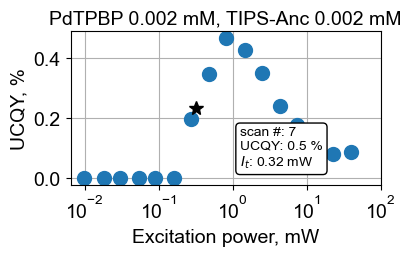

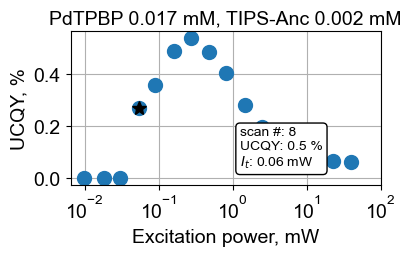

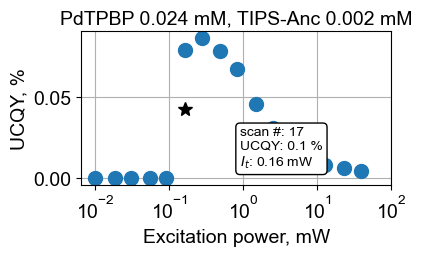

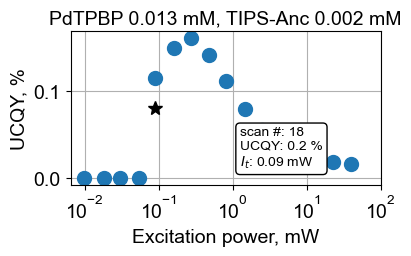

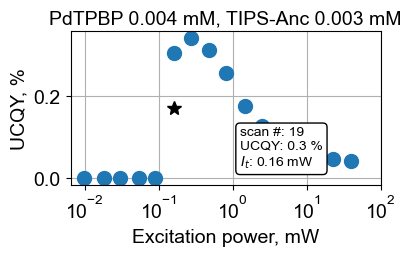

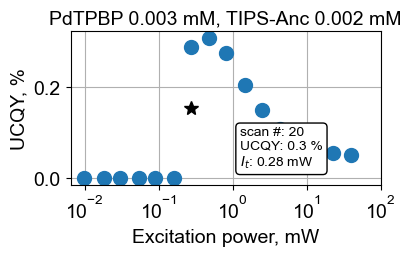

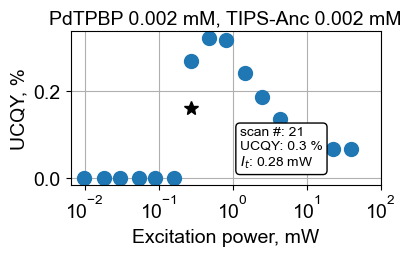

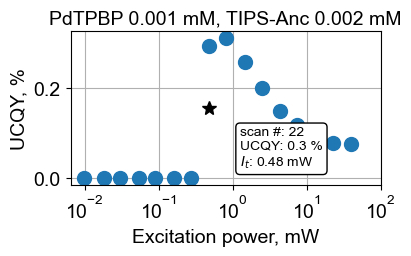

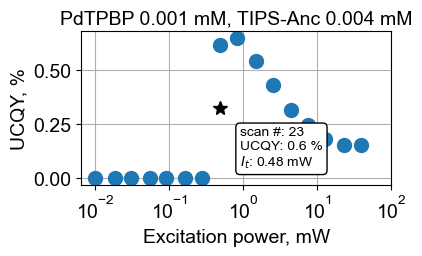

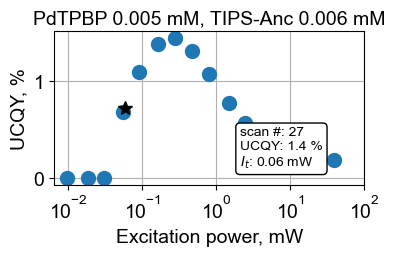

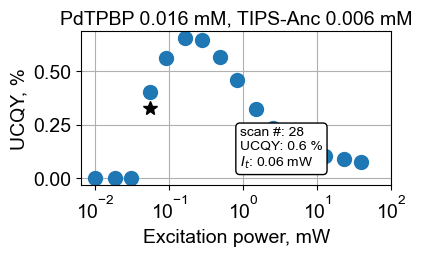

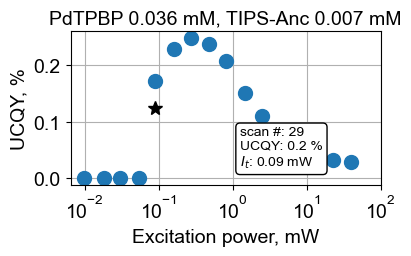

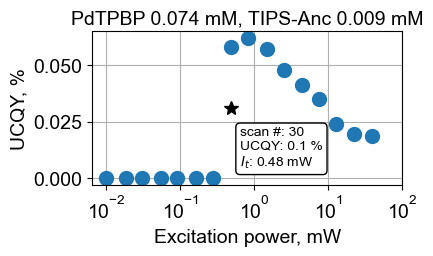

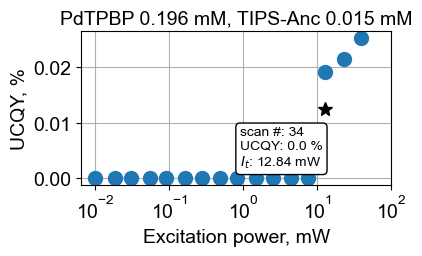

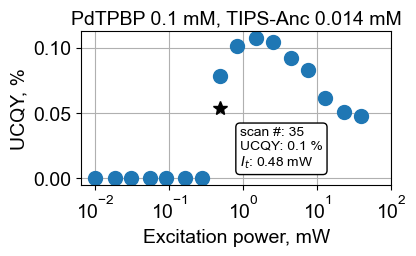

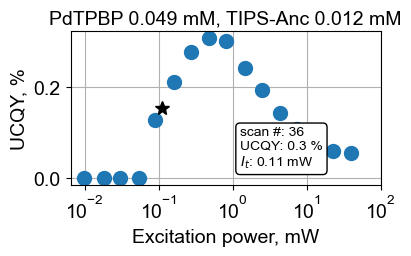

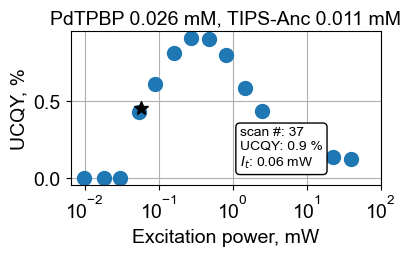

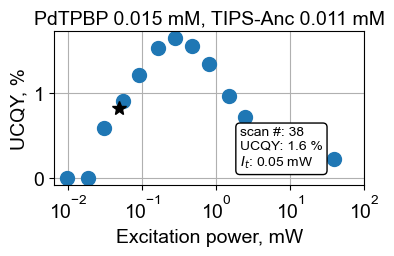

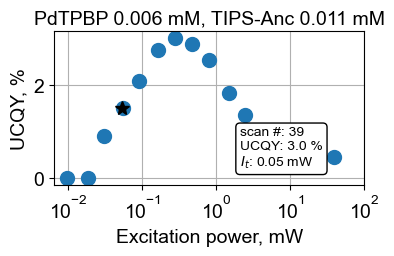

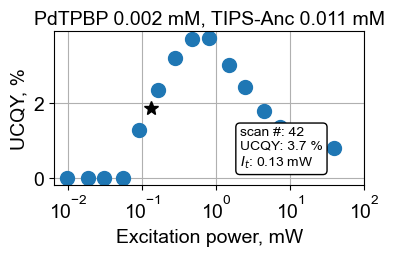

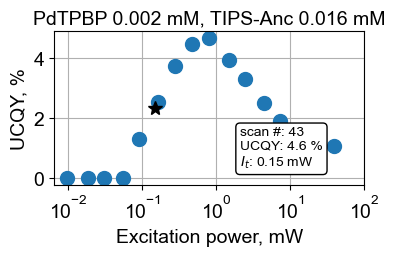

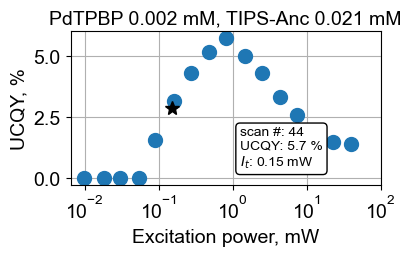

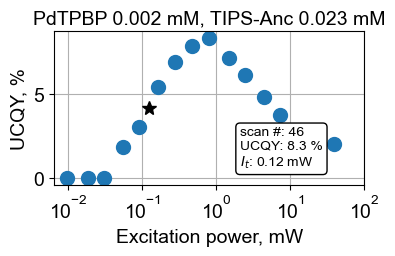

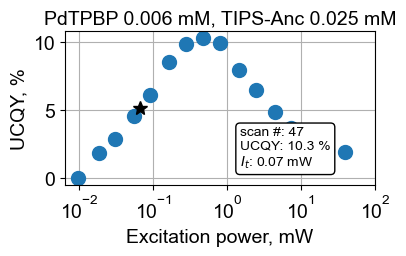

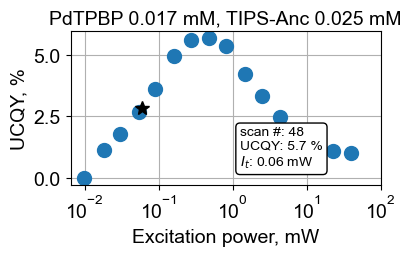

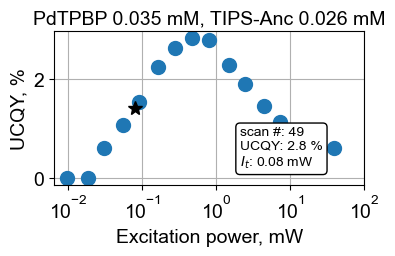

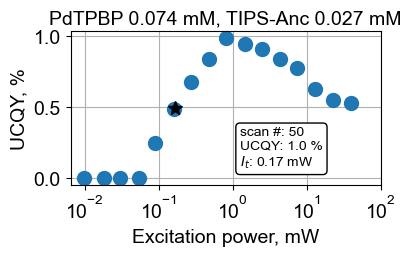

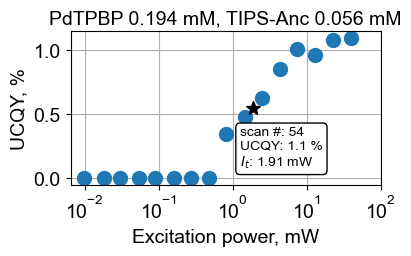

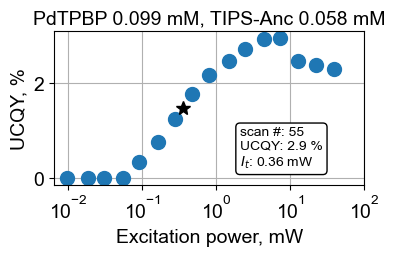

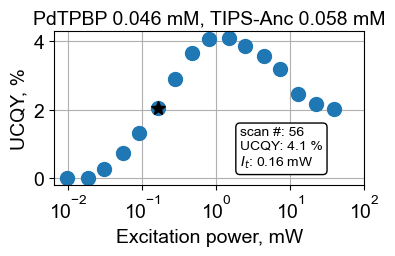

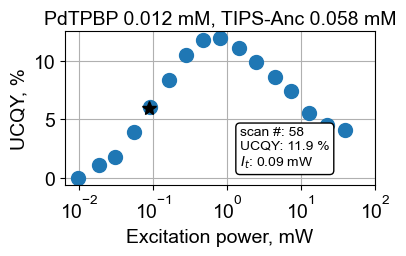

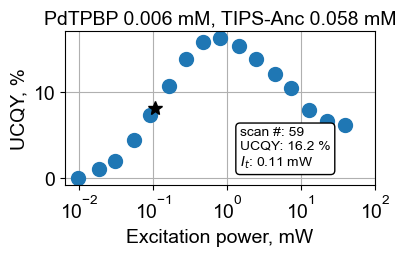

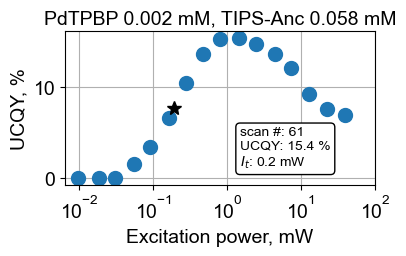

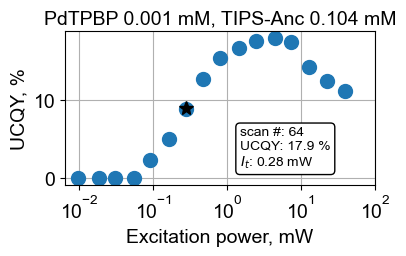

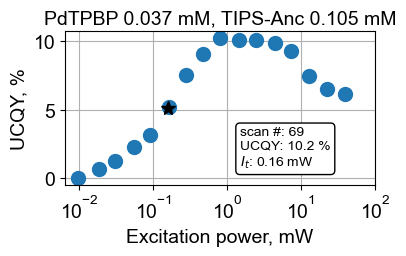

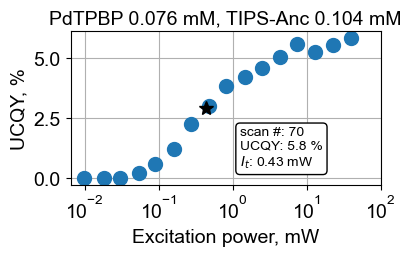

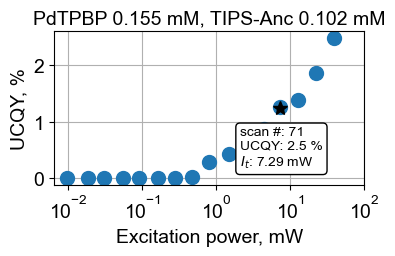

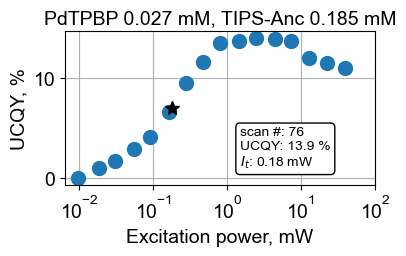

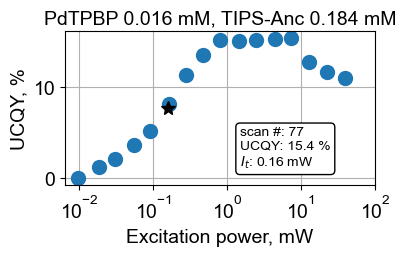

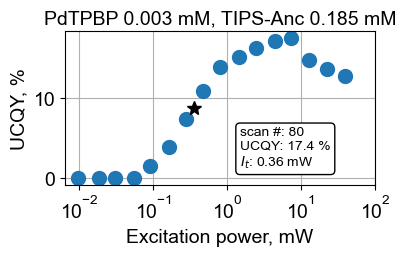

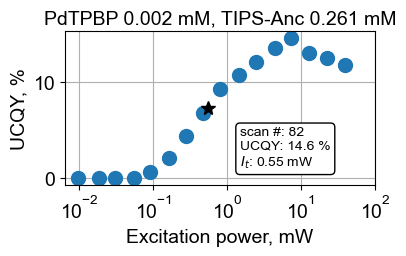

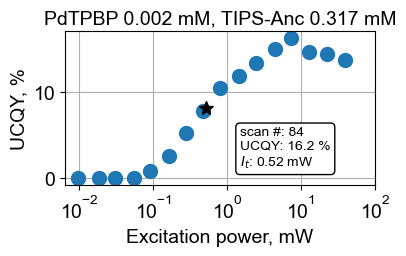

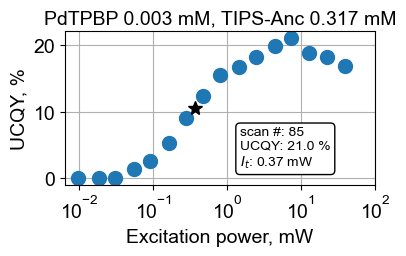

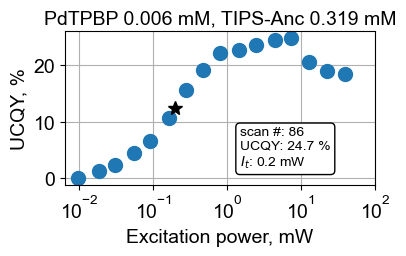

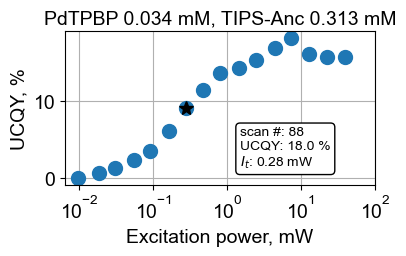

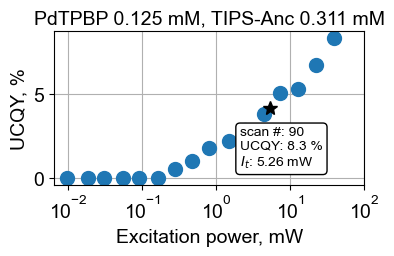

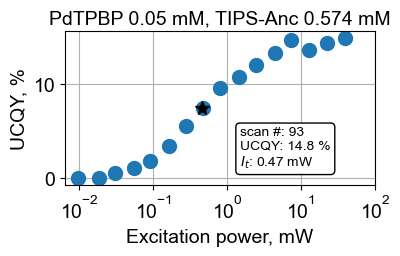

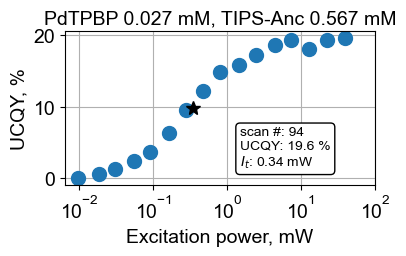

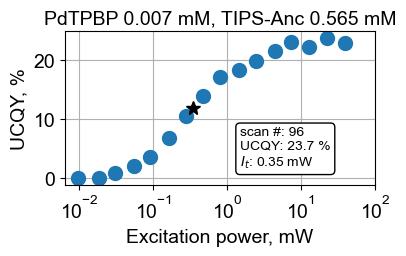

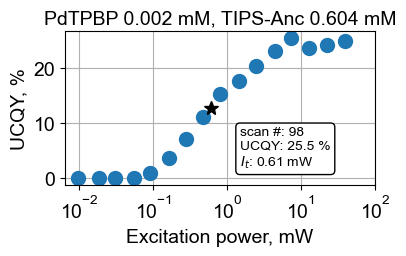

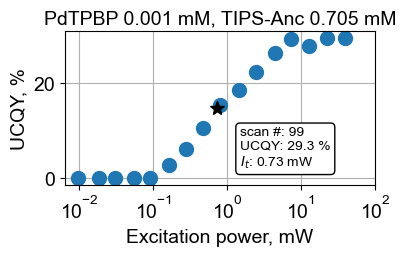

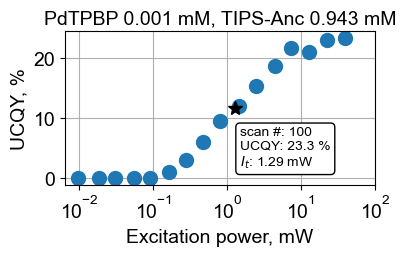

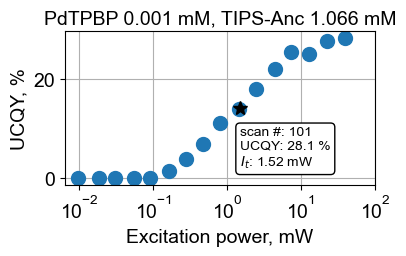

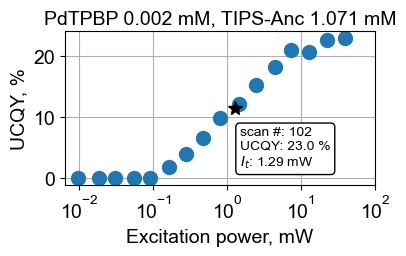

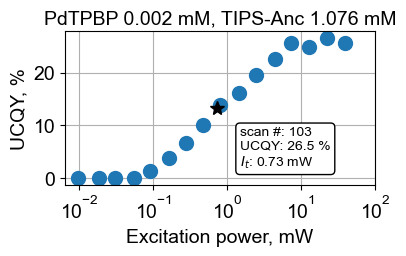

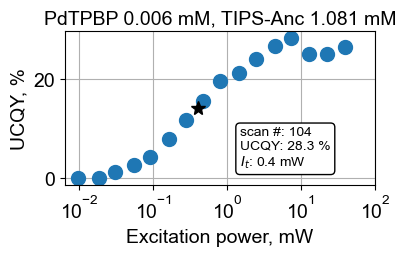

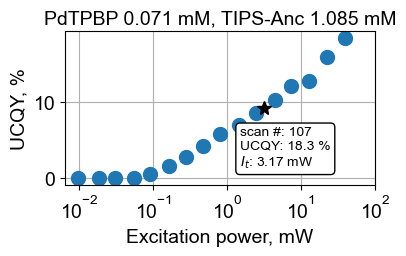

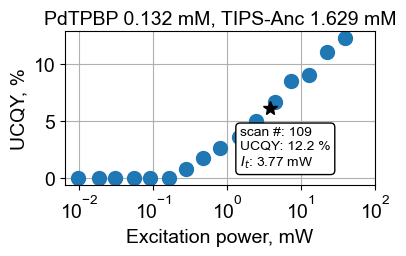

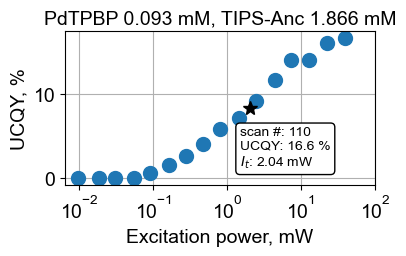

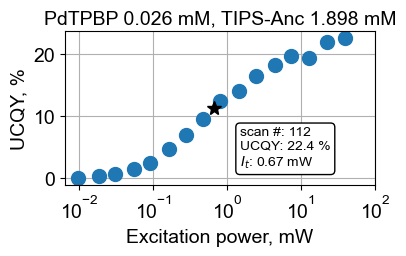

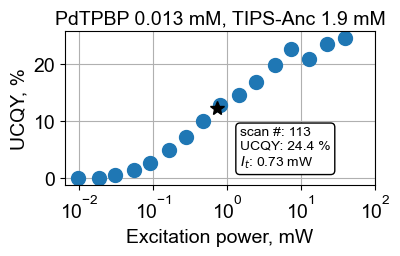

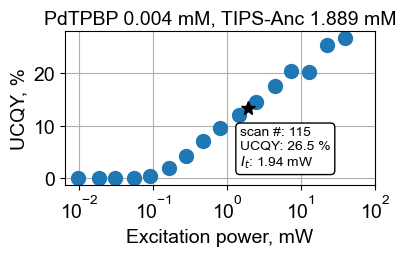

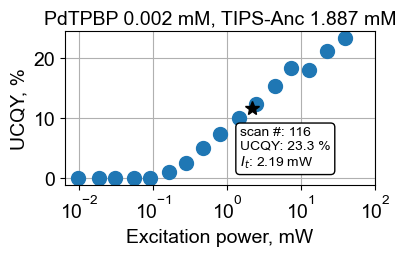

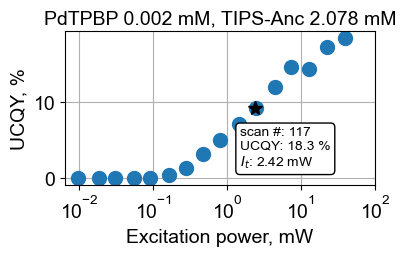

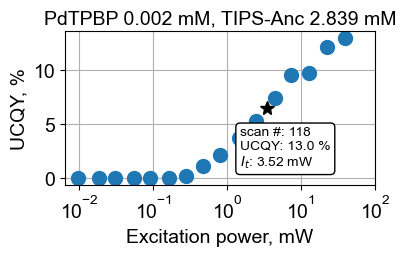

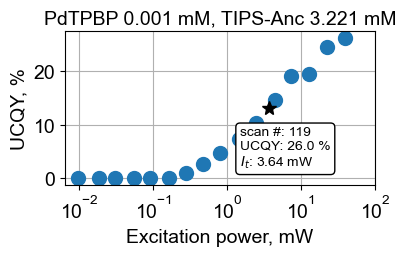

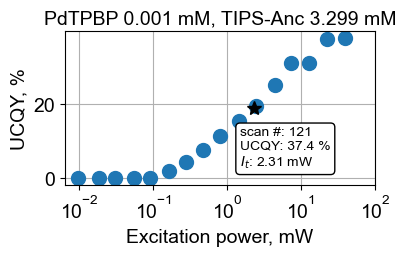

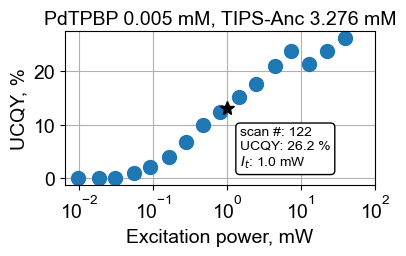

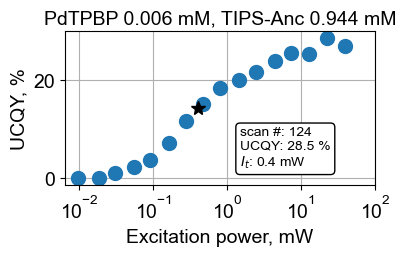

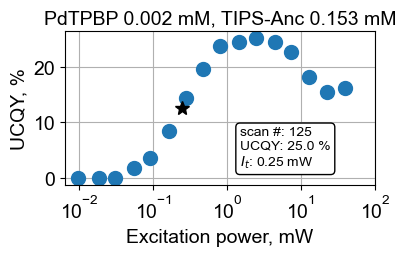

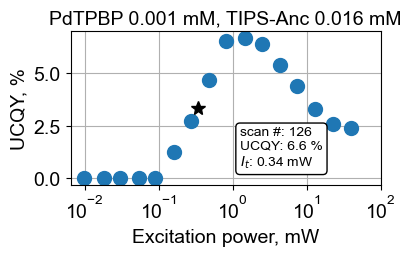

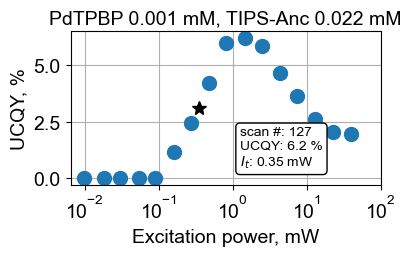

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1.
 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 0.
 0. 1. 0. 0. 1. 1. 1. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 0. 0. 0. 0.]


In [7]:
# Extract maximum UCQY, threshold and maximum PhosQY

plt.rcParams["figure.figsize"] = 4,2
plt.rcParams['figure.dpi'] = 100
plt.rcParams.update({'font.size': 14})

emit_conc_PL = 1000*emit_conc[start_iteration:] #in mM
sens_conc_PL = 1000*sens_conc[start_iteration:]

lim = 0
x = power_axis[lim:]

QY_max = np.zeros(n_pl)
QY_array = np.zeros(n_pl)
I_th_array = np.zeros(n_pl)
MaxPL_array = np.zeros(n_pl)
PhosQY_max = np.zeros(n_pl)
UCQY_limit = np.zeros(n_pl) #when max UCQY is not reached at max power, equals to 1

for i in range(n_pl):
    QY_max[i] = np.max(PLQY[lim:,i])
    MaxPL_array[i] = np.max(MaxPL[lim:,i])
    PhosQY_max[i] = np.max(PhosQY[lim:,i])

    #Estimate threshold
    y = PLQY[lim:,i]
    low_lim = 0
    high_lim = y.argmax()
    if high_lim == len(y)-1:
        UCQY_limit[i] = 1
    for q in range(len(y)):
        if y[q]>0:
            low_lim = q
            break              

    x_limited = x[low_lim : high_lim]
    y_limited = y[low_lim : high_lim]

    if max(y) == 0 or len(y_limited) == 0:
        continue

        #temportary for finding Phosphorescene QY
    QY_array[i] = round(QY_max[i],3)

    #Use highest PLQY value if the highest excitation value is lower, otherwise use fitted QY and I_th values
    x_limited_strech = np.linspace(x_limited[0], x_limited[-1], len(x_limited)*20) #extrapolate for more accurate threshold value
    y_limited_strech = np.interp(x_limited_strech, x_limited, y_limited)
    Ith_index = (np.abs(y_limited_strech - QY_max[i]/2)).argmin() # threshold at half om maximum UCQY
    I_th_array[i] = round(x_limited_strech[Ith_index],3)  #use Ith at half QY value when saturated values are reached            

    QY = QY_array[i]
    I_th = I_th_array[i]

    if UCQY_limit[i] == 1:
        plt.plot(x, y, "o", markersize=10) #plot UCQY red if last value is max
    else:
        plt.plot(x, y, "o", markersize=10) #plot UCQY
    plt.plot(I_th_array[i],QY_array[i]/2,"k*", markersize=10) #plot threshold
#         plt.plot(x, PhosQY[lim:,i], "rx", markersize=10) #plot phos

#         plt.plot(x, y, "o", label=f"scan: {i+1}\n UCQY: {round(QY_array[i],1)} %\n $I_t$: {round(I_th_array[i],2)} mW")
    plt.title(f"PdTPBP {round(sens_conc_PL[i],3)} mM, TIPS-Anc {round(emit_conc_PL[i],3)} mM", size=14)
    plt.annotate(f"scan #: {i}\nUCQY: {round(QY_array[i],1)} %\n$I_t$: {round(I_th_array[i],2)} mW", size=10, xy=(0.6,0.45), xycoords = 'figure fraction', bbox=dict(facecolor='w', edgecolor='k', boxstyle='round,pad=0.3'))

    plt.grid()
#         plt.yscale("log")
    plt.xscale("log")
    plt.xticks([1E-2, 1E-1, 1E+0, 1E+1, 1E+2])
#         plt.tick_params(axis='x', which='minor')
    plt.xlabel('Excitation power, mW')
    plt.ylabel('UCQY, %')
    plt.show()

print(UCQY_limit)

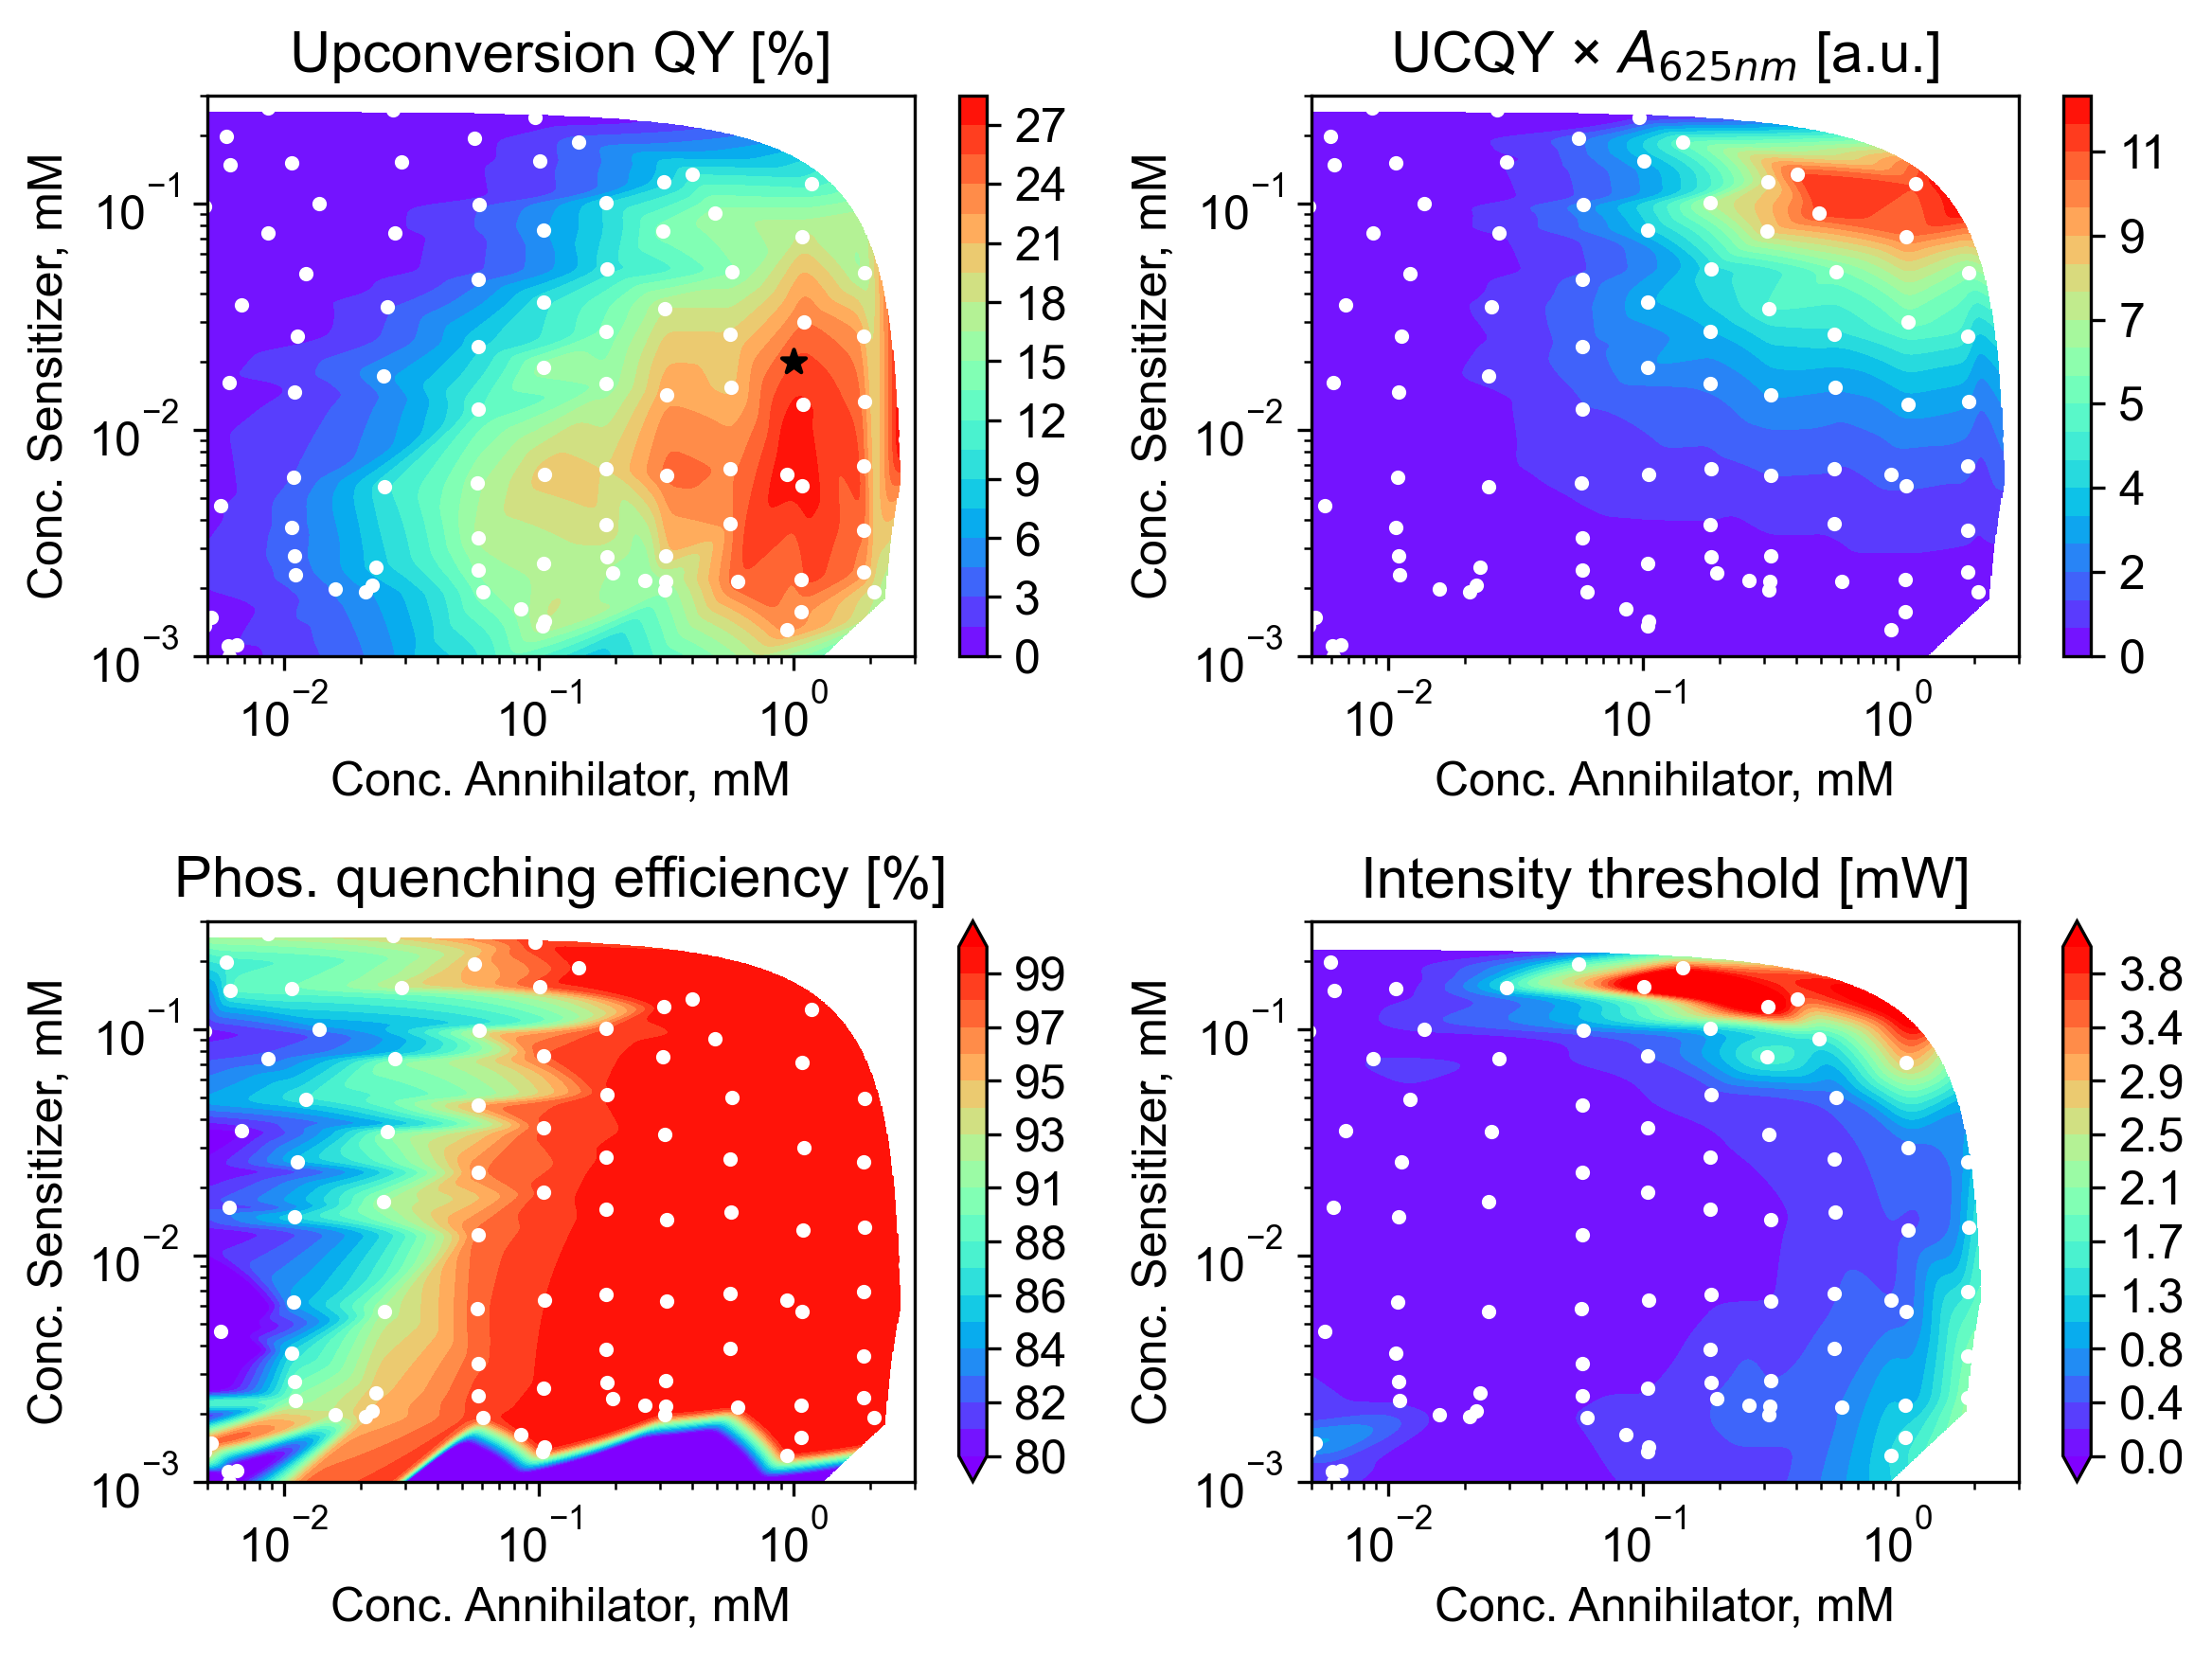

In [17]:
from scipy import interpolate
import scipy.ndimage as ndimage
from matplotlib import cm, ticker

# remove_index = [34,98,99,100,101,102,103,119,120,121,123,124,125,126,127]
remove_index = [34,99,101,119,120,121,125,126,127]

#calculate TET efficiency for PdTPBP. Also cal be called phos quenching efficiency
TET = np.zeros(n_pl)
for i in range(n_pl):
    if PhosQY_max[i] == 0:
        TET[i] = TET[i-1] 
    else:
        TET[i] = (1 - PhosQY_max[i]/9)*100
# print(PhosQY_max)

index_show = np.linspace(0,len(emit_conc_PL)-1,len(emit_conc_PL), dtype=int) #for ease of identifying bad points

emit_conc_PL_plot = np.delete(emit_conc_PL, remove_index)
sens_conc_PL_plot = np.delete(sens_conc_PL, remove_index)
QY_array_plot = np.delete(QY_array, remove_index)
# MaxPL_array = MaxPL_array / MaxPL_array[102] #np.max(MaxPL_array_plot) #normalize
MaxPL_array_plot = np.delete(MaxPL_array, remove_index)
MaxPL_array_plot = MaxPL_array_plot * 1.2 #np.max(MaxPL_array_plot) #normalize at max absorbance 625nm
I_th_array_plot = np.delete(I_th_array, remove_index)
index_show_plot = np.delete(index_show, remove_index)
TET_plot = np.delete(TET, remove_index)
UCQY_limit_plot = np.delete(UCQY_limit, remove_index)

x = np.geomspace(3E-3, 100, 1000)
y = np.geomspace(0.5E-3, 0.4, 1000)

X,Y = np.meshgrid(x, y)

# Interpolate (x,y,z) points over a normal (x,y) grid [X,Y]
QY_array_interp = interpolate.griddata((emit_conc_PL_plot,sens_conc_PL_plot),QY_array_plot, (X,Y), method='linear', rescale=True)
QY_array_interp = ndimage.gaussian_filter(QY_array_interp, sigma=5, order=0)
MaxPL_array_interp = interpolate.griddata((emit_conc_PL_plot,sens_conc_PL_plot),MaxPL_array_plot, (X,Y), method='linear', rescale=True)
MaxPL_array_interp = ndimage.gaussian_filter(MaxPL_array_interp, sigma=5, order=0)
TET_interp = interpolate.griddata((emit_conc_PL_plot,sens_conc_PL_plot),TET_plot, (X,Y), method='linear', rescale=True)
TET_interp = ndimage.gaussian_filter(TET_interp, sigma=5, order=0)
Ith_array_interp = interpolate.griddata((emit_conc_PL_plot,sens_conc_PL_plot),I_th_array_plot, (X,Y), method='linear', rescale=True)
Ith_array_interp = ndimage.gaussian_filter(Ith_array_interp, sigma=10, order=0)

plt.rcParams["figure.figsize"] = 8,6
plt.rcParams['figure.dpi'] = 300
plt.rcParams.update({'font.size': 12})
fig, ax = plt.subplots(2,2)

ax[0,0].set_title("Upconversion QY [%]")
cont_QY = ax[0,0].contourf(X, Y, QY_array_interp, levels=20, cmap="rainbow")
ax[0,1].set_title("UCQY × $A_{625nm}$ [a.u.]")
cont_MaxPL = ax[0,1].contourf(X, Y, MaxPL_array_interp, levels=20, cmap="rainbow")
ax[1,0].set_title("Phos. quenching efficiency [%]")
cont_TET = ax[1,0].contourf(X, Y, TET_interp, levels=np.linspace(80,100,20) , cmap="rainbow", extend='both')
ax[1,1].set_title("Intensity threshold [mW]")
# cont_Ith = ax[2].contourf(X, Y, Ith_array_interp, levels=np.geomspace(0.02,10,80), locator=ticker.LogLocator(subs='auto'), cmap="rainbow")
cont_Ith = ax[1,1].contourf(X, Y, Ith_array_interp, levels=np.linspace(0,4,20), cmap="rainbow", extend='both')


for axis in fig.get_axes():
# Add white points of measurement to the plots
    axis.scatter(emit_conc_PL_plot, sens_conc_PL_plot, s=7, marker='o',color='w')
#     axis.scatter(emit_conc_PL, sens_conc_PL, s=7, marker='o',color='w') # plot all points
# Plot limit points in different color
#     for x in range(len(emit_conc_PL_plot)): 
#         if UCQY_limit_plot[x] == 1:
#             axis.scatter(emit_conc_PL[x], sens_conc_PL[x], s=20, marker='x',color='w') # plot all points
#         else:
#             axis.scatter(emit_conc_PL[x], sens_conc_PL[x], s=7, marker='o',color='w') # plot all points
# Plot numbers
#     for x in range(len(emit_conc_PL_plot)):   
#         axis.scatter(emit_conc_PL_plot[x], sens_conc_PL_plot[x], s=40, marker=f'${index_show_plot[x]}$',color='w')
    axis.set(xlabel='Conc. Annihilator, mM', ylabel='Conc. Sensitizer, mM')
    axis.set_yscale("log")
    axis.set_xscale("log")
    axis.set_xlim([5E-3,3])
    axis.set_ylim([1E-3,0.3])
    
plt.colorbar(cont_QY, ax=ax[0,0], format="%0.0f")
plt.colorbar(cont_MaxPL, ax=ax[0,1], format="%0.0f")
plt.colorbar(cont_TET, ax=ax[1,0], format="%0.0f")
plt.colorbar(cont_Ith, ax=ax[1,1], format="%0.1f")

fig.tight_layout()

# ax[0,0].scatter([1,1], [0.02,1], s=400, marker='$27$%',color='k') #one and only
ax[0,0].scatter([1,1], [0.02,1], s=40, marker='*',color='k')


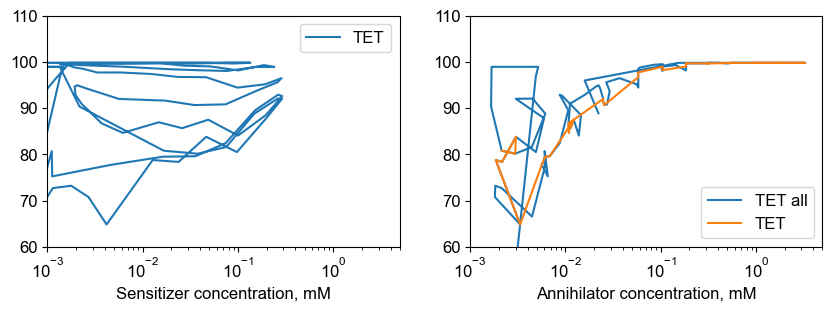

In [9]:
# Plot and save slices

plt.rcParams["figure.figsize"] = 10,3
plt.rcParams['figure.dpi'] = 100

fig, ax = plt.subplots(1,2)

TET_export = []
emit_export = []
for i in range(n_pl):
    if 3E-3 < sens_conc_PL[i] < 7E-2:
        TET_export.append(TET[i])        
        emit_export.append(emit_conc_PL[i])
        

ax[0].plot(sens_conc_PL, TET, label="TET")
# plt.scatter(1000*concentration_values[0,:], Ratio[-2,:], label="E/S PL Ratio")
# ax.set_ylim([0,120])
ax[0].set_xscale("log")
ax[0].legend()
ax[0].set_xlabel('Sensitizer concentration, mM')
ax[0].set_xlim([1E-3,5])
ax[0].set_ylim([60,110])

ax[1].plot(emit_conc_PL, TET, label="TET all")
ax[1].plot(emit_export, TET_export, label="TET")
ax[1].set_xscale("log")
ax[1].legend()
ax[1].set_xlabel('Annihilator concentration, mM')
ax[1].set_xlim([1E-3,5])
ax[1].set_ylim([60,110])

Data_export = np.transpose(np.vstack([emit_export, TET_export]))
np.savetxt("TET vs ann conc TIPS-Ans PdTPBP.txt", Data_export) #delimiter="\t"

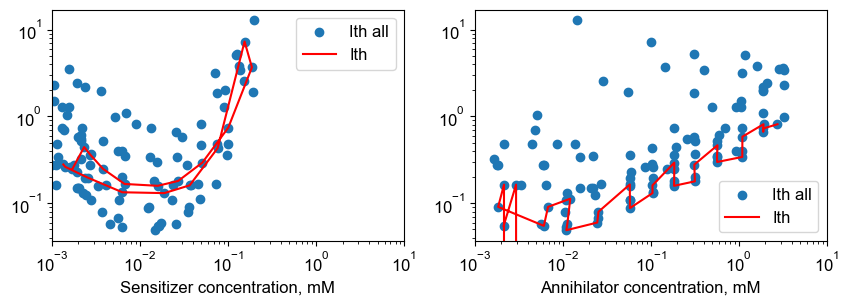

In [10]:
# Plot and save slices. Threshold vs annihilator conc

plt.rcParams["figure.figsize"] = 10,3
plt.rcParams['figure.dpi'] = 100

fig, ax = plt.subplots(1,2)

Ith_export = []
emit_export = []
Ith_export_s = []
sens_export = []
for i in range(n_pl):
    if 8E-3 < sens_conc_PL[i] < 60E-3: #filter sensitizer values
        Ith_export.append(I_th_array[i])        
        emit_export.append(emit_conc_PL[i])
    if 0.1 < emit_conc_PL[i] < 0.2: #filter emitter values
        Ith_export_s.append(I_th_array[i])        
        sens_export.append(sens_conc_PL[i])
        

ax[0].scatter(sens_conc_PL, I_th_array, label="Ith all")
ax[0].plot(sens_export, Ith_export_s, "r",label="Ith")
# plt.scatter(1000*concentration_values[0,:], Ratio[-2,:], label="E/S PL Ratio")
# ax.set_ylim([0,120])
ax[0].set_xscale("log")
ax[0].set_yscale("log")
ax[0].legend()
ax[0].set_xlabel('Sensitizer concentration, mM')
ax[0].set_xlim([1E-3,10])
# ax[0].set_ylim([60,110])

ax[1].scatter(emit_conc_PL, I_th_array, label="Ith all")
ax[1].plot(emit_export, Ith_export, "r",label="Ith")
ax[1].set_xscale("log")
ax[1].set_yscale("log")
ax[1].legend()
ax[1].set_xlabel('Annihilator concentration, mM')
ax[1].set_xlim([1E-3,10])
# ax[1].set_ylim([60,110])

Data_export = np.transpose(np.vstack([emit_export, Ith_export]))
np.savetxt("Ith vs ann conc TIPSA PdTPBP.txt", Data_export) #delimiter="\t"
Data_export_s = np.transpose(np.vstack([sens_export, Ith_export_s]))
np.savetxt("Ith vs sens conc TIPSA PdTPBP.txt", Data_export_s) #delimiter="\t"

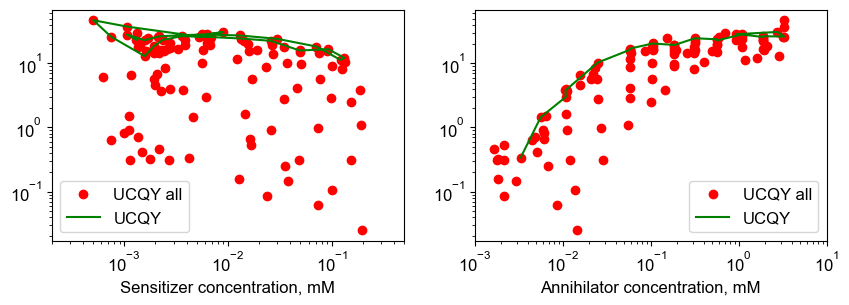

In [11]:
# Plot and save slices. UCQY vs annihilator conc

plt.rcParams["figure.figsize"] = 10,3
plt.rcParams['figure.dpi'] = 100

fig, ax = plt.subplots(1,2)

UCQY_export = []
emit_export = []
UCQY_export_s = []
sens_export = []
for i in range(n_pl):
    if 3E-3 < sens_conc_PL[i] < 10E-3: #filter sensitizer values
        UCQY_export.append(QY_array[i])        
        emit_export.append(emit_conc_PL[i])
    if 0.8 < emit_conc_PL[i] < 10: #filter emitter values
        UCQY_export_s.append(QY_array[i])        
        sens_export.append(sens_conc_PL[i])
        

ax[0].plot(sens_conc_PL, QY_array, "ro", label="UCQY all")
ax[0].plot(sens_export, UCQY_export_s, "g",label="UCQY")
# plt.scatter(1000*concentration_values[0,:], Ratio[-2,:], label="E/S PL Ratio")
# ax.set_ylim([0,120])
ax[0].set_xscale("log")
ax[0].set_yscale("log")
ax[0].legend()
ax[0].set_xlabel('Sensitizer concentration, mM')
ax[0].set_xlim([0.2E-3,0.5])
# ax[0].set_ylim([60,110])

ax[1].plot(emit_conc_PL, QY_array,"ro", label="UCQY all")
ax[1].plot(emit_export, UCQY_export, "g",label="UCQY")
ax[1].set_xscale("log")
ax[1].set_yscale("log")
ax[1].legend()
ax[1].set_xlabel('Annihilator concentration, mM')
ax[1].set_xlim([1E-3,10])
# ax[1].set_ylim([60,110])

Data_export = np.transpose(np.vstack([emit_export, UCQY_export]))
np.savetxt("UCQY vs ann conc TIPSA PdTPBP.txt", Data_export) #delimiter="\t"
Data_export_s = np.transpose(np.vstack([sens_export, UCQY_export_s]))
np.savetxt("UCQY vs sens conc TIPSA PdTPBP.txt", Data_export_s) #delimiter="\t"